In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
from glob import glob
import os
import statsmodels.api as sm
from typing import List
from sklearn.model_selection import train_test_split
import itertools
from tqdm import tqdm
from admix.data import quantile_normalize
import matplotlib.pyplot as plt
import calpgs
import subprocess
import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]
os.environ["R_HOME"] = "/u/project/pasaniuc/kangchen/software/miniconda3/envs/r/lib/R"

In [2]:
DATA_DIR = "../compile-data/out/per-trait-info/"
DATA_URL = "../r2-diff/data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

trait_list = df_display.id.values

COVAR_COLS = [
    "AGE",
    "SEX",
    "DEPRIVATION_INDEX",
    "log_BMI",
    "income",
    "ever_smoked",
    "drink_alcohol",
    "glasses",
    "years_of_edu",
] + [f"PC{i}" for i in range(1, 11)]
FIT_COLS = ["PGS"] + COVAR_COLS

In [3]:
df_params = pd.DataFrame(
    [params for params in itertools.product(trait_list, ["white", "other"])],
    columns=["trait", "group"],
)
df_params["out_prefix"] = df_params.apply(
    lambda r: f"out/joint-fit/{r.trait}-{r.group}", axis=1
)

In [4]:
def estimate(df, mean_cols, var_cols):
    df = df.copy()
    # format data set
    train_x = sm.add_constant(df[mean_cols])
    test_x = sm.add_constant(df[mean_cols])

    train_z = sm.add_constant(df[var_cols])
    test_z = sm.add_constant(df[var_cols])

    train_y = df["pheno"].values

    # adjust
    beta, gamma, beta_cov, gamma_cov = calpgs.fit_het_linear(
        y=train_y, mean_covar=train_x, var_covar=train_z, return_est_covar=True
    )

    beta_se = np.sqrt(np.diag(beta_cov))
    gamma_se = np.sqrt(np.diag(gamma_cov))

    df_beta_params = pd.DataFrame(
        {"beta": beta, "beta_se": beta_se, "beta_z": beta / beta_se},
        index=train_x.columns,
    )
    df_gamma_params = pd.DataFrame(
        {
            "gamma": gamma,
            "gamma_se": gamma_se,
            "gamma_z": gamma / gamma_se,
        },
        index=train_z.columns,
    )

    df_params = pd.merge(
        df_beta_params, df_gamma_params, left_index=True, right_index=True, how="outer"
    )

    pred_mean = test_x.dot(beta)
    pred_std = np.sqrt(np.exp(test_z.dot(gamma)))

    df["cal_pred"], df["cal_predstd"] = pred_mean, pred_std
    return df_params, df

In [5]:
def joint_fit(trait, indiv_group, out_prefix):
    df_trait = pd.read_csv(
        os.path.join(DATA_DIR, f"{trait}.tsv.gz"), index_col=0, sep="\t"
    )

    if indiv_group == "white":
        df_trait = df_trait[df_trait.group == "United Kingdom"]
    elif indiv_group == "other":
        df_trait = df_trait[~(df_trait.group == "United Kingdom")]
    else:
        raise NotImplementedError

    df_trait = df_trait.rename(columns={"MEAN": "PGS", "PHENO": "pheno"}).dropna(
        subset=["pheno", "PGS"]
    )

    # impute 0 and standardize covariates
    for col in ["PGS"] + COVAR_COLS:
        df_trait[col] = df_trait[col].fillna(0)
        df_trait[col] = (df_trait[col] - df_trait[col].mean()) / df_trait[col].std()

    df_trait = df_trait[["pheno", "PGS"] + COVAR_COLS]

    fit_cols = [col for col in FIT_COLS if col != trait]

    df_params, df_cal = estimate(df_trait, mean_cols=fit_cols, var_cols=fit_cols)
    df_params.to_csv(out_prefix + ".params.tsv", sep="\t", float_format="%.6g")
    df_cal.to_csv(out_prefix + ".predint.tsv", sep="\t", float_format="%.6g")


def marginal_fit(trait, indiv_group, out_prefix):
    df_trait = pd.read_csv(
        os.path.join(DATA_DIR, f"{trait}.tsv.gz"), index_col=0, sep="\t"
    )

    if indiv_group == "white":
        df_trait = df_trait[df_trait.group == "United Kingdom"]
    elif indiv_group == "other":
        df_trait = df_trait[~(df_trait.group == "United Kingdom")]
    else:
        raise NotImplementedError

    df_trait = df_trait.rename(columns={"MEAN": "PGS", "PHENO": "pheno"}).dropna(
        subset=["pheno", "PGS"]
    )

    # impute 0 and standardize covariates
    for col in ["PGS"] + COVAR_COLS:
        df_trait[col] = df_trait[col].fillna(0)
        df_trait[col] = (df_trait[col] - df_trait[col].mean()) / df_trait[col].std()

    df_trait = df_trait[["pheno", "PGS"] + COVAR_COLS]

    fit_cols = [col for col in FIT_COLS if col != trait]

    ### fit a marginal parameter for each covariate
    df_marginal_params = []
    for col in fit_cols:
        df_params, df_cal = estimate(df_trait, mean_cols=fit_cols, var_cols=[col])
        df_marginal_params.append(df_params.loc[col].iloc[3:])
    df_marginal_params = pd.DataFrame(df_marginal_params)
    df_marginal_params.to_csv(out_prefix + ".params.tsv", sep="\t", float_format="%.6g")
    return df_marginal_params

In [6]:
for _, params in tqdm(df_params.iterrows(), total=len(df_params)):
    joint_fit(params.trait, params.group, params.out_prefix)
    marginal_fit(
        params.trait, params.group, params.out_prefix.replace("joint", "marginal")
    )

100%|██████████| 22/22 [11:14<00:00, 30.65s/it]


# Summarize results

In [16]:
dict_df_sum = dict()
for method in ["marginal", "joint"]:
    for group in ["white", "other"]:
        df_sum = pd.DataFrame(index=FIT_COLS, columns=trait_list)
        for trait in trait_list:
            df = pd.read_csv(
                f"out/{method}-fit/{trait}-{group}.params.tsv", sep="\t", index_col=0
            )
            df_sum[trait] = df["gamma_z"]
        df_sum.to_csv(
            f"out/fit-summary/{method}-{group}.tsv",
            float_format="%.6g",
            sep="\t",
            na_rep="NA",
        )
        dict_df_sum[method, group] = df_sum

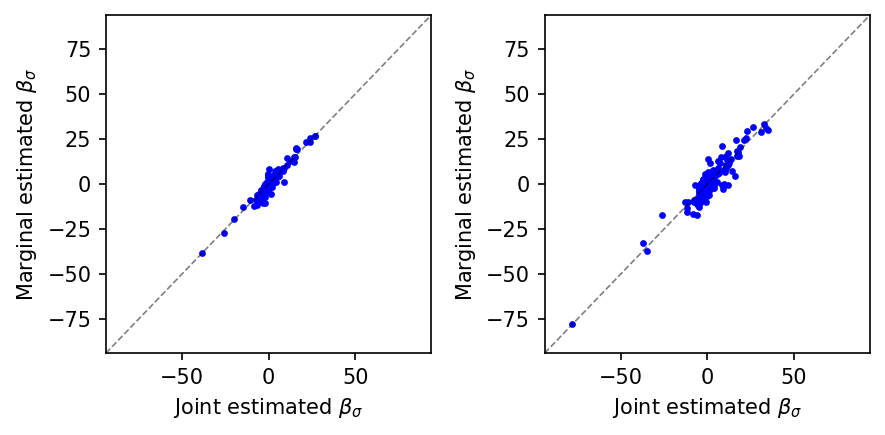

In [47]:
fig, axes = plt.subplots(
    figsize=(6, 3),
    dpi=150,
    ncols=2,
)

lim = 0
for i, group in enumerate(["white", "other"]):
    ax = axes[i]
    x = dict_df_sum["joint", group].values.flatten()
    y = dict_df_sum["marginal", group].values.flatten()
    lim = max(np.nanmax(np.abs(x)), np.nanmax(np.abs(y)))
    ax.scatter(
        x,
        y,
        s=5,
        color="blue",
    )
    ax.axline((0, 0), slope=1, ls="--", color="black", alpha=0.5, lw=0.8)
    ax.set_xlabel(r"Joint estimated $\beta_\sigma$")
    ax.set_ylabel(r"Marginal estimated $\beta_\sigma$")

lim *= 1.2
for i in range(2):
    axes[i].set_xlim(-lim, lim)
    axes[i].set_ylim(-lim, lim)

fig.tight_layout()
fig.show()